# oective 
20231114
sarahfong

learn the features of the US MPRA dataset

do some basic transformations and comparisons 

## transformations
- done previously in ./EMF/US/1_EDA-US--replicates.scaling.ipynb

- recap: 
    - log2 the RNA/DNA ratio
    - compute mean, medians across replicates
    - compute delta mean, median as difference between ctrl and us
    - call categorical active exceeding 95% shuffle confidence intervals
        - active = > 97.5%
        - silent = < 2.5% 
    - compute p-values as non-parametric t-test between replicates of ctrl, US for each tile. 
    - compute response as categorical active us != ctrl AND t-test pval<0.05
    - compute peak-wise response as repeated measures between all tiles in a peak +/- US exposure
    

## Here:
- distributions of control groups? 
- sample fold change x p-value

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, StandardScaler

import sys

# Read, write to config

In [2]:
LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    DATA_PATH = "/Users/sarahfong/Desktop/local_data/EMF/US"
import config_readwrite as crw
import plot_params as pp

In [3]:
pp.fonts()

('sans-serif', 'Arial', 18)

In [4]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

# path
#DATA_PATH = config["local_path"]["data"]

# make dictionary of values to write to config
config_dict = {
    "HEPG2": os.path.join(DATA_PATH, "full_hepg2_MPRA.csv"),
    "HEPG2.clean": os.path.join(DATA_PATH, "full_hepg2_MPRA.clean.csv"),
    "HEPG2.clean.transformed": os.path.join(DATA_PATH, "full_hepg2_MPRA.clean.transformed.csv"),
    "HEPG2.clean.trans.scaled": os.path.join(DATA_PATH, "full_hepg2_MPRA.clean.transformed.standard.scaled.csv"),
    "BJ": os.path.join(DATA_PATH, "full__MPRA.csv"),
    "BJ.clean": os.path.join(DATA_PATH, "full_bj_MPRA.clean.csv"),
    "BJ.clean.transformed": os.path.join(DATA_PATH, "full_bj_MPRA.clean.transformed.csv"),
    "BJ.clean.trans.scaled": os.path.join(DATA_PATH, "full_bj_MPRA.clean.transformed.standard.scaled.csv"),
    "FASTA":os.path.join(DATA_PATH, "ultrasound_final_no_adapter.fasta")
}

# make data section of config
section = "data"
crw.check(config, section)

# add dictionary to config
for key, value in config_dict.items():
    config[section][key] = value
    
# write to config    
crw.write(config, cfn)

# functions 

In [1]:
def callResponse(df):
    df["response"] = False

    df.loc[(df["pval"] < 0.05) &
           (df['label.ctrl'] != df['label.us']),
           "response"
           ] = True

    # describe direction of values
    df["direction"] = None

    # direction when US is positive and ctrl is negative
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] >= 0), "direction"] = "US_UP"

    # when US is negative and ctrl is positive
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] <= 0), "direction"] = "US_DOWN"

    # Less silent when US is negative and ctrl is negative and US > CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "LESS_SILENT"

    # More silent when US is negative and ctrl is negative and US < CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "MORE_SILENT"

    # Less active when US is positive and ctrl is positive and CTRL > US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "LESS_ACTIVE"
    # more active when US is positive and ctrl is positive and CTRL < US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "MORE_ACTIVE"

    return df

# test CL 

## notes about this dataset
- Activity score - median score was assigned per US|CTRL for each sequence
- Active | inactive = test sequence score > 95% shuffled score. Both these scores are median score (above)
- logFC
- P-value

### input data

In [5]:
CL= "HEPG2" #
DATA = config_dict[CL]
CLEAN = config_dict[f"{CL}.clean.transformed"]
SCALED =config_dict[f'{CL}.clean.trans.scaled']

# files to write
SIG_PEAK = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.dif.act.tiles.tsv")
SIG_PEAK_TILES = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.act.tiles.tsv")

### CD candidates

In [182]:
CD_PATH = "/Users/sarahfong/Desktop/local_data/EMF/US/results/CD_candidates"
CD_UP = os.path.join(CD_PATH, f"{CL.lower()}_up.csv")
CD_DOWN = os.path.join(CD_PATH, f"{CL.lower()}_down.csv")

In [183]:
cand_dict = {}
samples = [("UP", CD_UP), ('DOWN', CD_DOWN)]

for direction_name, file in samples:
    dirdf = pd.read_csv(file)
    dirdf["dir"] = direction_name
    cand_dict[direction_name] = dirdf

candidates = pd.concat(cand_dict.values())

candidates = candidates[['insert',
                         'type.x',
                         'label',
                         'control_ratio',
                         'n_obs_bc.x',
                         'ultrasound_ratio',
                         'n_obs_bc.y',
                         'pval',
                         'logFC',
                         'dir']].drop_duplicates()

### constants dict

In [8]:
constants = {
    "NAMES" :['name',
         'label',
         'ratio.med.ctrl',
         'label.ctrl',
         'ratio.1.ctrl',
         'ratio.2.ctrl',
         'ratio.3.ctrl',
         'ratio.med.us',
         'label.us',
         'ratio.1.us',
         'ratio.2.us',
         'ratio.3.us',
         'pval',
              "p_adj", 
         'logFC',
         'response'],
    
    "CTRL_LIST" : ["NegCt", "PosCt", "Shuffle", "Synthetic", 'H3K27AC', "ATAC", "DEG", "non-diff"],
    
    "RATIOS": ['ratio.1.ctrl','ratio.2.ctrl', 'ratio.3.ctrl', 
          'ratio.1.us', 'ratio.2.us','ratio.3.us'],
    
    "L2RATIOS": ['l2.ratio.1.ctrl','l2.ratio.2.ctrl', 'l2.ratio.3.ctrl', 
          'l2.ratio.1.us', 'l2.ratio.2.us','l2.ratio.3.us'],
    "L2STD": ['l2.ratio.std.ctrl', 'l2.ratio.std.us'],
    
    "CL_LIST" :["k562", "hob", "", "hepg2"]
}

### load data

In [9]:
df = pd.read_csv(CLEAN, sep='\t')
t = pd.read_csv(SCALED, sep='\t')

In [10]:
ratios=constants["L2RATIOS"]

### Data transforms

In [11]:
# change datatype
df["pval"] = df["pval"].astype(float)
t["pval"] = t["pval"].astype(float)

df["-log10p"] = np.log10(df["pval"])*-1
t["-log10p"] = np.log10(t["pval"])*-1

### annotate CD candidates

In [12]:
candidate_names = set(candidates["insert"])
df["candidate"], t["candidate"] = None, None
df.loc[df["name"].isin(candidate_names), "candidate"]= True
t.loc[t["name"].isin(candidate_names), "candidate"]= True

# US v. ctrl

### logFC distribution of datatypes

<AxesSubplot:xlabel='logFC', ylabel='Density'>

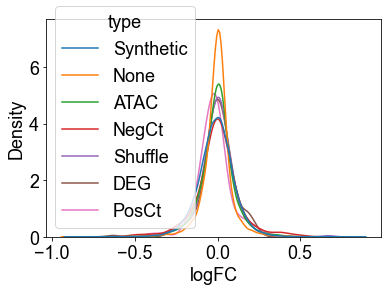

In [13]:
col = "logFC"
fig, ax = plt.subplots()
sns.kdeplot(x=col, data=df, hue= "type", common_norm=False)
#ax.legend(bbox_to_anchor=(1,1))

ValueError: Could not interpret value `type` for parameter `hue`

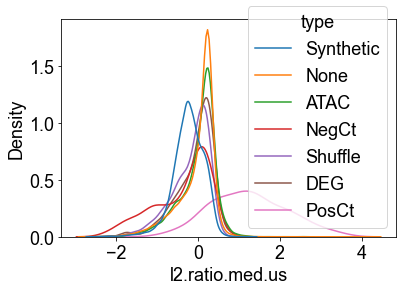

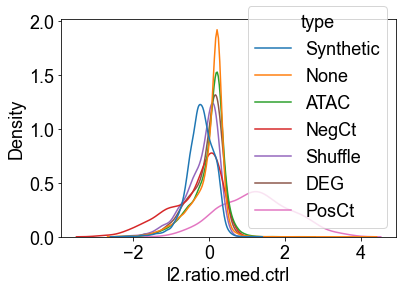

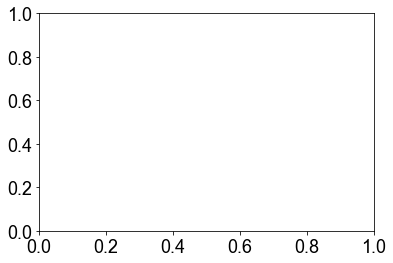

In [14]:
cols = ["l2.ratio.med.us", "l2.ratio.med.ctrl"]
datas = [df, t]
for data in datas:
    for col in cols:
        fig, ax = plt.subplots()
        sns.kdeplot(x=col, data=data, 
                    #label = col, 
                    hue="type", common_norm=False)
        #ax.legend(bbox_to_anchor=(1,1))

# correlation between ctrl x US
- raw values. Need to be centered per ctrl/US condition?

In [15]:
data_dict = {"raw":(df, [-4,5]),
            'standardized': (t, [-6,9])}

## median

In [16]:
def jointPlot(x, y, data, id_):
    
    # pick color
    if "med" in x:
        color = "b"
    elif "mean" in x:
        color = "g"
    else:
        color="orange"
        
    data["sig"] = data["pval"].apply(lambda x: True if x <0.05 else False)
    hue = "sig"
    g = sns.jointplot(x=x,
                  y=y,
                  data=data,
                  color=color,
                  hue=hue,
                  marginal_ticks=True, 
                  alpha=0.4,
                  marginal_kws={"common_norm":False}, 
                      joint_kws={"legend":False}
             )


    # don't plot identity line when looking at fc
    #if "delta" not in y:
     #   plt.plot(id_,id_, c="k", ls="--")
    
    # axes
    plt.axhline(0, c="grey", ls="--")
    plt.axvline(0, c="grey", ls="--")
    
    plt.legend(["Sig", "Non-sig"])
    return g

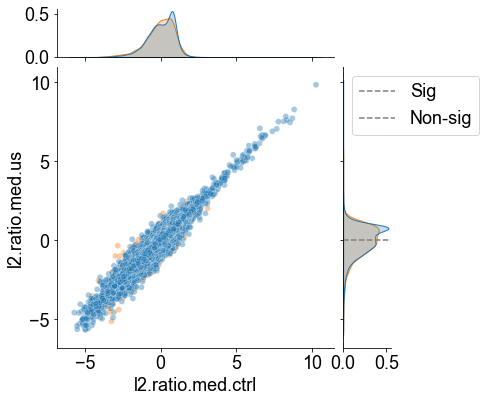

In [17]:
x="l2.ratio.med.ctrl"
y="l2.ratio.med.us"

data, id_ = data_dict["standardized"]

jointPlot(x, y, data, id_)

### activity x fold change

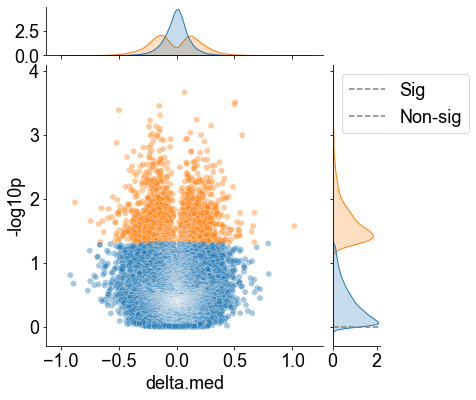

In [18]:
x= "delta.med"
y= "-log10p"


data, id_ = data_dict["raw"]

id_ = [1,3]
fig = jointPlot(x, y, data, id_)

out = os.path.join(DATA_PATH, f"{CL}.delta.median.logp.jpg")

plt.savefig(out, bbox_inches="tight", dpi=160)

# CD validation 

In [ ]:
def jointPlot(x, y, data, id_):
    data["sig"] = data["pval"].apply(lambda x: True if x <0.05 else False)
    hue = "candidate"
    
    g = sns.jointplot(x=x,
                  y=y,
                  data=data,
                  hue=hue,
                  marginal_ticks=True, 
                  #alpha=0.4,
                  marginal_kws={"common_norm":False}, 
                      joint_kws={"legend":False}
             )


    # axes
    plt.axhline(0, c="grey", ls="--")
    plt.axvline(0, c="grey", ls="--")
    
    plt.legend(["Sig", "Non-sig"])
    return g

## manipulate the candidate column
#- when False, data gets plotted
#- when None, data does not get plotted

In [21]:
candidate_names = set(candidates["insert"])
data["candidate"]= False
data["candidate2"]= None
data.loc[data["name"].isin(candidate_names), "candidate"]= True
data.loc[data["name"].isin(candidate_names), "candidate2"]= True


data["response2"] = None
data.loc[data["response"]==True, "response2"] = True
data["response_candidate"] = data["response"].map(str) +", "+data["candidate"].map(str)
data["response2_candidate2"] = data["response2"].map(str) +", "+data["candidate2"].map(str)

## plot responsive only

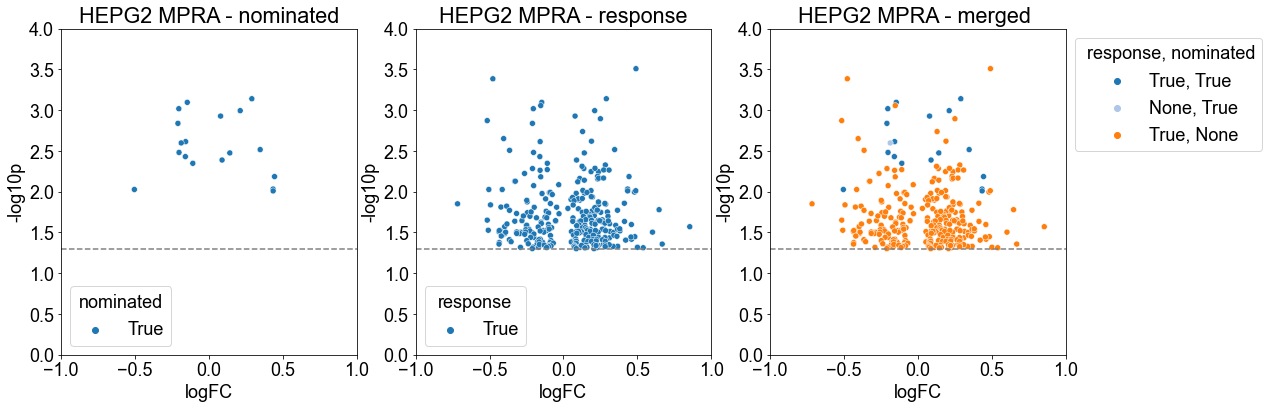

In [22]:
x= "logFC"
y= "-log10p"

data, id_ = data_dict["raw"]

fig, (ax1, ax2, ax3)=plt.subplots(ncols=3, figsize=(18,6))

hue="candidate2"
sns.scatterplot(x=x, y=y, data=data, hue=hue,  palette="tab10", ax=ax1)
ax1.legend(title="nominated", loc="lower left")

# plot alpha
alpha= np.log10(0.05) *-1
ax1.axhline(alpha, ls="--", c="grey", label = "alpha")

ax1.set(title=f"{CL} MPRA - nominated", 
      xlim =(-1,1), 
       ylim=(0,4))
#out = os.path.join(DATA_PATH, ".response.nominated.pdf")

hue="response2"
sns.scatterplot(x=x, y=y, data=data, hue=hue,  palette="tab10", ax=ax2)

ax2.legend(title="response",loc="lower left")

# plot alpha
alpha= np.log10(0.05) *-1
ax2.axhline(alpha, ls="--", c="grey", label = "alpha")

ax2.set(title=f"{CL} MPRA - response", 
      xlim =(-1,1),
        ylim=(0,4))

# response and candidate
hue ="response2_candidate2"
hue_order = ["True, True", "None, True", "True, None"]
sns.scatterplot(x=x, y=y, data=data.loc[data[hue]!="None, None"], hue=hue,
                hue_order=hue_order, palette="tab20", ax=ax3)
ax3.legend(title=" response, nominated", bbox_to_anchor =(1,1),)

# plot alpha
alpha= np.log10(0.05) *-1
ax3.axhline(alpha, ls="--", c="grey", label = "alpha")

ax3.set(title=f"{CL} MPRA - merged ", 
      xlim =(-1,1), 
       ylim = (0,4))
out = os.path.join(DATA_PATH, ".candidates_only.pdf")
plt.savefig(out, bbox_inches = "tight", dpi=90)

## plot all data

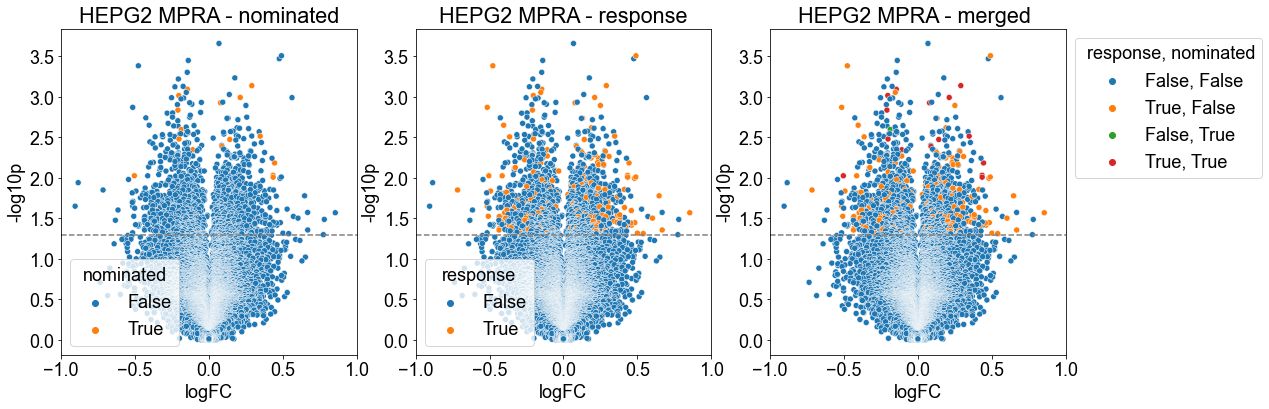

In [23]:
x= "logFC"
y= "-log10p"

data, id_ = data_dict["raw"]

fig, (ax1, ax2, ax3)=plt.subplots(ncols=3, figsize=(18,6))

hue="candidate"
sns.scatterplot(x=x, y=y, data=data, hue=hue,  palette="tab10", ax=ax1)
ax1.legend(title="nominated", loc="lower left")

# plot alpha
alpha= np.log10(0.05) *-1
ax1.axhline(alpha, ls="--", c="grey", label = "alpha")

ax1.set(title=f"{CL} MPRA - nominated", 
      xlim =(-1,1))
#out = os.path.join(DATA_PATH, ".response.nominated.pdf")

hue="response"
sns.scatterplot(x=x, y=y, data=data, hue=hue,  palette="tab10", ax=ax2)

ax2.legend(title="response",loc="lower left")

# plot alpha
alpha= np.log10(0.05) *-1
ax2.axhline(alpha, ls="--", c="grey", label = "alpha")

ax2.set(title=f"{CL} MPRA - response", 
      xlim =(-1,1))

# response and candidate
hue ="response_candidate"
hue_order = ["False, False", "True, False", "False, True", "True, True"]
sns.scatterplot(x=x, y=y, data=data, hue=hue,  hue_order=hue_order, palette="tab10", ax=ax3)
ax3.legend(title=" response, nominated", bbox_to_anchor =(1,1),)

# plot alpha
alpha= np.log10(0.05) *-1
ax3.axhline(alpha, ls="--", c="grey", label = "alpha")

ax3.set(title=f"{CL} MPRA - merged ", 
      xlim =(-1,1))
out = os.path.join(DATA_PATH, ".candidates_alldata.pdf")
plt.savefig(out, bbox_inches = "tight", dpi=90)

## compare p-value calculations between SF (a)  and CD (b)

In [25]:
b = candidates[['insert',"pval", "logFC"]].sort_values(by="logFC").copy()

a = df.loc[df.candidate==True, ["name", "candidate", 'pval','response', 'delta.mean',"logFC"]].sort_values(by="logFC").copy()

c = pd.merge(a,b, left_on='name', right_on="insert")
c[["name", "pval_x", "pval_y"]]

,name,pval_x,pval_y
0,hob_atac_up_chr17:538152-538421,0.009392,0.004066
1,hob_atac_up_chr2:127153718-127153987,0.001451,0.001502
2,SYNTHETIC:_Added_CCCCCCCC_AGGCCTGG_CTGATAAGGA_...,0.000959,0.001194
3,hob_atac_up_chr18:24076189-24076458,0.003300,0.004004
4,hepg2_atac_down_chr2:237298688-237298957,0.002522,0.002489
5,hob_k27ac_up_chr4:94561079-94561348,0.003709,0.003853
6,hob_k27ac_up_chr16:69855432-69855701,0.002430,0.001980
7,hob_k27ac_down_chr19:10193979-10194248,0.000802,0.000617
8,hob_atac_up_chr13:31756504-31756773,0.004482,0.003605
9,hob_k27ac_up_chr1:28071863-28072132,0.001181,0.000976


### only some correlation between SF and CD t-tests. Parameteric v. non? idk what she did? 

In [26]:
c[["pval_x", "pval_y"]].corr(method="spearman")

,pval_x,pval_y
pval_x,1.000000,0.874097
pval_y,0.874097,1.000000


## nominate?

### add peak info

In [27]:
peaks = pd.read_csv(SIG_PEAK_TILES, sep='\t')
peaks

,Unnamed: 0,name,l2.ratio.med.ctrl,label.ctrl,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.med.us,label.us,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,delta.med,dif,enh.id,enh.name,peak_p,peak_stat
0,1,hob_k27ac_down_chr19:10193979-10194248,0.369708,1,0.386682,0.369708,0.357039,0.223528,0,0.245193,0.204966,0.223528,-0.146180,US.off,chr19:10193979-10194780,enh.5124,0.004060,15.647159
1,7,hob_k27ac_up_chr4:22501185-22501454,0.149826,0,0.149826,0.155226,0.143202,0.035619,0,0.035619,0.020544,0.047037,-0.114206,no.effect.off,chr4:22501053-22501854,enh.7990,0.038990,2.277310
2,2367,hob_k27ac_up_chr4:22501053-22501322,-0.118287,0,-0.119279,-0.118287,-0.088350,-0.212917,0,-0.212917,-0.129322,-0.247765,-0.094630,no.effect.off,chr4:22501053-22501854,enh.7990,0.038990,2.277310
3,9332,hob_k27ac_up_chr4:22501452-22501721,-0.986695,0,-1.118644,-0.950646,-0.986695,-1.136369,0,-1.136369,-1.224461,-0.972704,-0.149674,no.effect.off,chr4:22501053-22501854,enh.7990,0.038990,2.277310
4,13325,hob_k27ac_up_chr4:22501585-22501854,0.154592,0,0.209182,0.111739,0.154592,0.192449,0,0.135533,0.232407,0.192449,0.037857,no.effect.off,chr4:22501053-22501854,enh.7990,0.038990,2.277310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,14323,k562_atac_up_chr15:78902293-78902562,0.063969,0,0.063969,0.342729,0.004627,0.002920,0,0.002920,0.180839,-0.008799,-0.061049,no.effect.off,chr15:78902293-78902694,enh.3525,0.045221,2.653772
1356,12913,bj_atac_down_chr17:27197517-27197786,0.327520,1,0.411773,0.327520,0.186074,0.248093,0,0.358595,0.248093,0.096172,-0.079427,US.off,chr17:27197517-27197918,enh.4294,0.021005,6.790710
1357,15049,k562_atac_down_chr6:169659606-169659875,0.590303,1,0.288484,0.590303,0.714926,0.679035,1,0.430963,0.679035,0.782236,0.088732,no.effect.on,chr6:169659540-169659941,enh.9555,0.046958,-4.450557
1358,16524,bj_k27ac_up_chr7:100436342-100436611,0.419058,1,0.419058,0.121964,0.456614,0.488941,1,0.488941,0.218111,0.505660,0.069883,no.effect.on,chr7:100435943-100436744,enh.9921,0.034281,-5.261121


### add peak info

In [28]:
df = pd.merge(df, peaks[["name", "enh.id", "peak_p"]], how="left").drop_duplicates()

## silencing

In [29]:
df.loc[
    (df["logFC"] < -0.25)
    & (df["response"] == True)
    & (df["peak_p"] < 0.05),
    ["name", "logFC", "candidate",
     "pval", "peak_p", "response",
     "label.ctrl", "label.us",
     "l2.ratio.med.ctrl",
     "l2.ratio.med.us",
     'l2.ratio.1.ctrl',
     'l2.ratio.2.ctrl',
     'l2.ratio.3.ctrl',
     'l2.ratio.1.us',
     'l2.ratio.2.us',
     'l2.ratio.3.us',
     'ratio.med.ctrl', 'ratio.med.us',]].sort_values(by="logFC").tail(10)

,name,logFC,candidate,pval,peak_p,response,label.ctrl,label.us,l2.ratio.med.ctrl,l2.ratio.med.us,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,ratio.med.ctrl,ratio.med.us
258,hob_k27ac_down_chr7:66627968-66628237,-0.422974,False,0.015417,0.019115,True,1,0,0.595843,0.101234,0.595843,0.676870,0.518341,0.085155,0.327187,0.101234,1.514110,1.129353
588,hepg2_k27ac_down_chr7:116953106-116953375,-0.414400,False,0.009398,0.000261,True,1,0,0.530334,0.173312,0.530334,0.491631,0.703867,0.228228,0.086532,0.173312,1.493054,1.120285
1313,hob_atac_down_chr14:73472122-73472391,-0.397602,False,0.026750,0.034510,True,1,0,0.485532,0.054341,0.330957,0.634523,0.485532,-0.017671,0.226463,0.054341,1.403458,1.065391
27,bj_atac_down_chr1:147640884-147641153,-0.364399,False,0.003107,0.018018,True,1,0,0.259387,-0.126900,0.282542,0.259387,0.215323,-0.126900,-0.169041,-0.042110,1.191423,0.925488
565,hob_k27ac_down_chr21:46298041-46298310,-0.329173,False,0.022994,0.029855,True,0,-1,-0.876053,-1.190295,-0.789420,-0.966274,-0.876053,-1.095132,-1.338806,-1.190295,0.545086,0.433885
944,hob_k27ac_down_chr2:221572570-221572839,-0.296322,False,0.032598,0.038014,True,0,-1,-0.808157,-1.164748,-0.808157,-0.765893,-0.940183,-0.999974,-1.164748,-1.243608,0.560122,0.456122


hob_k27ac_down_chr7:66627968-66628237
hob_atac_down_chr14:73472122-73472391
bj_atac_down_chr1:147640884-147641153

### activating

In [33]:
df.loc[
    (df["logFC"] > 0.30)
    & (df["response"] == True)
    & (df["peak_p"] < 0.05),
    ["name", "logFC", "candidate",
     "pval", "peak_p", "response",
     "label.ctrl", "label.us",
     "l2.ratio.med.ctrl",
     "l2.ratio.med.us",
     'l2.ratio.1.ctrl',
     'l2.ratio.2.ctrl',
     'l2.ratio.3.ctrl',
     'l2.ratio.1.us',
     'l2.ratio.2.us',
     'l2.ratio.3.us',
     'ratio.med.ctrl', 'ratio.med.us',]].sort_values(by="logFC", ascending=False)

,name,logFC,candidate,pval,peak_p,response,label.ctrl,label.us,l2.ratio.med.ctrl,l2.ratio.med.us,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,ratio.med.ctrl,ratio.med.us
664,Neg_vikram_75_DNasePeakNoPromoter1402_chr1:373...,0.489965,False,0.009725,0.020099,True,-1,0,-1.271410,-0.838223,-1.222111,-1.338271,-1.271410,-0.838223,-0.881554,-0.650378,0.412801,0.579743
111,hob_k27ac_down_chr15:75844211-75844480,0.434541,True,0.009268,0.006685,True,0,1,-0.034768,0.414392,-0.079027,0.111607,-0.034768,0.412320,0.480639,0.414392,1.001105,1.352974
2120,hob_k27ac_down_chr16:2904526-2904795,0.421496,False,0.039229,0.024434,True,0,1,-0.152542,0.355394,-0.001859,-0.191340,-0.152542,0.451283,0.096120,0.355394,0.924723,1.238495
1003,hepg2_atac_up_chr16:85650086-85650355,0.367721,False,0.046701,0.039078,True,0,1,0.245575,0.545365,0.245575,-0.015217,0.315607,0.645856,0.473326,0.545365,1.139869,1.470788
923,hepg2_atac_down_chr1:41417200-41417469,0.301827,False,0.020058,0.035914,True,0,1,0.103119,0.410427,0.123572,-0.006739,0.103119,0.410427,0.456753,0.253885,1.052954,1.297981


### add activating
hob_k27ac_down_chr16:2904526-2904795 # more on
hepg2_atac_up_chr16:85650086-85650355 # more on
hepg2_atac_down_chr1:41417200-41417469 # more on

### NOMINATIONS

In [84]:
noms = ["hob_k27ac_down_chr16:2904526-2904795",  # more on
        "hepg2_atac_up_chr16:85650086-85650355",  # more on
        "hepg2_atac_down_chr1:41417200-41417469",  # more on
        "hob_k27ac_down_chr7:66627968-66628237",  # less on
        "hob_atac_down_chr14:73472122-73472391",  # less on
        "bj_atac_down_chr1:147640884-147641153",  # less on
        ]
noms_active = ["hob_k27ac_down_chr16:2904526-2904795",  # more on
               "hepg2_atac_up_chr16:85650086-85650355",  # more on
               "hepg2_atac_down_chr1:41417200-41417469",  # more on
               ]


In [85]:
data["nom_SF"] = None
data.loc[data["name"].isin(noms), "nom_SF"] = True

data.loc[data["name"].isin(noms)]

,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,ratio.1.us,...,delta.med,delta.mean,-log10p,candidate,sig,candidate2,response2,response_candidate,response2_candidate2,nom_SF
27,bj_atac_down_chr1:147640884-147641153,Differential_ATAC,1.191423,1,1.216336,1.196970,1.160964,0.925488,0,0.915797,...,-0.386286,-0.365101,2.507624,False,True,None,True,"True, False","True, None",True
258,hob_k27ac_down_chr7:66627968-66628237,Differential_H3K27ac,1.514110,1,1.511355,1.598668,1.432307,1.129353,0,1.060802,...,-0.494608,-0.425825,1.812008,False,True,None,True,"True, False","True, None",True
923,hepg2_atac_down_chr1:41417200-41417469,Differential_ATAC,1.052954,0,1.089429,0.995340,1.074093,1.297981,1,1.329079,...,0.307308,0.300371,1.697718,False,True,None,True,"True, False","True, None",True
1003,hepg2_atac_up_chr16:85650086-85650355,Differential_ATAC,1.139869,0,1.185566,0.989507,1.244535,1.470788,1,1.564667,...,0.299789,0.372861,1.330675,False,True,None,True,"True, False","True, None",True
1313,hob_atac_down_chr14:73472122-73472391,Differential_ATAC,1.403458,1,1.257848,1.552424,1.400102,1.065391,0,0.987826,...,-0.431190,-0.395960,1.572672,False,True,None,True,"True, False","True, None",True
2120,hob_k27ac_down_chr16:2904526-2904795,Differential_H3K27ac,0.924723,0,0.998712,0.875792,0.899664,1.238495,1,1.367256,...,0.507936,0.416180,1.406390,False,True,None,True,"True, False","True, None",True


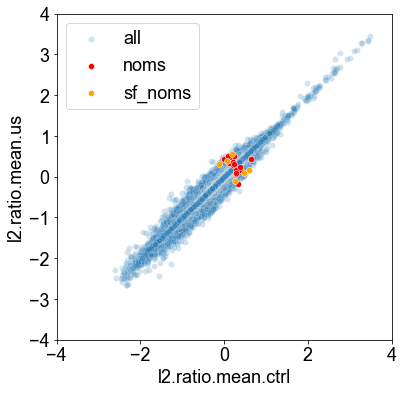

In [72]:
fig, ax=plt.subplots(figsize=(6,6))
sns.scatterplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                data=data, alpha=0.2)
sns.scatterplot(x="l2.ratio.mean.ctrl", 
                y="l2.ratio.mean.us", data=data.loc[data["candidate"] == True], color="red")

sns.scatterplot(x="l2.ratio.mean.ctrl", 
                y="l2.ratio.mean.us", data=data.loc[data["nom_SF"] == True], color="orange")

ax.set(ylim=(-4,4), xlim=(-4,4))
ax.legend(["all", "noms", "sf_noms"])

## add noms back to CD's original dataframe

In [86]:
hepg2 = pd.read_csv(config[section][CL])

# add CD candidate annotations
hepg2["candidate"] = False
hepg2.loc[hepg2["oligo"].isin(candidate_names), "candidate"] = True


# add peak info to original 
hepg2 = pd.merge(hepg2, peaks[["name", "enh.id", "peak_p"]], how="left", left_on = "oligo", right_on = "name").drop_duplicates()

In [87]:
hepg2.loc[
    (hepg2["logFC"]>0.45)
    &(hepg2["peak_p"] < 0.05),
       ["oligo", 'candidate', "logFC",  "pval", "peak_p", "status",
       "status_control", "status_ultrasound",
       'ratio_control','ratio_ultrasound',]].sort_values(by="logFC", ascending=False)

,oligo,candidate,logFC,pval,peak_p,status,status_control,status_ultrasound,ratio_control,ratio_ultrasound
664,Neg_vikram_75_DNasePeakNoPromoter1402_chr1:373...,False,0.489965,0.020503,0.020099,unresponsive,inactive,inactive,0.412801,0.579743
265,hob_k27ac_down_chr19:18417170-18417439,False,0.455851,0.009829,0.018792,unresponsive,inactive,inactive,0.653630,0.896513


In [179]:
# annotate nominations up and down
nomsdf = hepg2.loc[hepg2["oligo"].isin(noms)].sort_values(by="logFC", ascending=False)

nomsdf["dir"] = "DOWN"
nomsdf.loc[nomsdf["oligo"].isin(noms_active), "dir"] = "UP"

# annotate nomination criteria
nomsdf["type.x"] = "logFC<-0.25_peakp<0.05_responseTrue"
nomsdf.loc[nomsdf["oligo"].isin(noms_active), "type.x"] = "logFC>0.3_peakp<0.05_responseTrue"
nomsdf

,oligo,label,ratio_control,status_control,ratio.1.x,ratio.2.x,ratio.3.x,ratio_ultrasound,status_ultrasound,ratio.1.y,...,pval,p_adjusted,logFC,status,candidate,name,enh.id,peak_p,dir,type.x
2120,hob_k27ac_down_chr16:2904526-2904795,Differential_H3K27ac,0.924723,inactive,0.998712,0.875792,0.899664,1.238495,active,1.367256,...,0.054649,0.998986,0.421496,unresponsive,False,hob_k27ac_down_chr16:2904526-2904795,chr16:2904127-2904928,0.024434,UP,logFC>0.3_peakp<0.05_responseTrue
1003,hepg2_atac_up_chr16:85650086-85650355,Differential_ATAC,1.139869,inactive,1.185566,0.989507,1.244535,1.470788,active,1.564667,...,0.029367,0.998986,0.367721,unresponsive,False,hepg2_atac_up_chr16:85650086-85650355,chr16:85650019-85650420,0.039078,UP,logFC>0.3_peakp<0.05_responseTrue
923,hepg2_atac_down_chr1:41417200-41417469,Differential_ATAC,1.052954,inactive,1.089429,0.995340,1.074093,1.297981,active,1.329079,...,0.027280,0.998986,0.301827,unresponsive,False,hepg2_atac_down_chr1:41417200-41417469,chr1:41417068-41417469,0.035914,UP,logFC>0.3_peakp<0.05_responseTrue
27,bj_atac_down_chr1:147640884-147641153,Differential_ATAC,1.191423,inactive,1.216336,1.196970,1.160964,0.925488,inactive,0.915797,...,0.001441,0.998986,-0.364399,unresponsive,False,bj_atac_down_chr1:147640884-147641153,chr1:147640752-147641153,0.018018,DOWN,logFC<-0.25_peakp<0.05_responseTrue
1313,hob_atac_down_chr14:73472122-73472391,Differential_ATAC,1.403458,active,1.257848,1.552424,1.400102,1.065391,inactive,0.987826,...,0.036567,0.998986,-0.397602,unresponsive,False,hob_atac_down_chr14:73472122-73472391,chr14:73472055-73472456,0.034510,DOWN,logFC<-0.25_peakp<0.05_responseTrue
258,hob_k27ac_down_chr7:66627968-66628237,Differential_H3K27ac,1.514110,active,1.511355,1.598668,1.432307,1.129353,inactive,1.060802,...,0.009684,0.998986,-0.422974,unresponsive,False,hob_k27ac_down_chr7:66627968-66628237,chr7:66627968-66628769,0.019115,DOWN,logFC<-0.25_peakp<0.05_responseTrue


In [180]:
# rename columnns
# make nom df like CD's original candidate df
nomsdf = nomsdf.rename(columns={
    "oligo": "insert",
    "ratio_control": "control_ratio",
    "ratio_ultrasound": "ultrasound_ratio"})

In [181]:
# column order for output
output_order = ['insert',
                 'type.x',
                 'label',
                 'pval',
                 'peak_p',
                 'logFC',
                 'control_ratio',
                 'ultrasound_ratio',
                  'dir',
                 "enh.id", 
                 ]

In [184]:
# add peak information to candidates
if "peak_p" not in list(candidates):
    candidates = pd.merge(candidates, peaks[["name", "enh.id", "peak_p"]],
                      how="left", left_on="insert", right_on="name").drop_duplicates()

In [185]:
candidates

,insert,type.x,label,control_ratio,n_obs_bc.x,ultrasound_ratio,n_obs_bc.y,pval,logFC,dir,name,enh.id,peak_p
0,SYNTHETIC:_Added_CCCCCGCCCC_AATATTACAT_AGCAACC...,"top_3_significant_bc100, top_3_largest_logFC_b...",Synthetic,1.175913,123,1.250761,124,0.004739,0.089025,UP,NaN,NaN,NaN
1,SYNTHETIC:_Added_GCCCGGGGG_AGGCCTGG_ACACACACAC...,"top_5_significant, top_5_largest_logFC, pval_p...",Synthetic,1.096270,12,1.394352,12,0.001401,0.346992,UP,NaN,NaN,NaN
2,SYNTHETIC:_Added_GTATCAAAGT_TTTTATAA_TTTTATAA_...,"top_5_largest_logFC, pval_plus_logFC",Synthetic,1.061129,30,1.434469,31,0.004572,0.434918,UP,NaN,NaN,NaN
3,SYNTHETIC:_Added_TCCTTATCTC_GGTGACTG_GCCCGGGGG...,"top_5_largest_logFC, pval_plus_logFC",Synthetic,0.998831,23,1.359127,23,0.003508,0.444368,UP,NaN,NaN,NaN
4,hob_atac_up_chr17:82288410-82288679,top_5_significant,Differential_ATAC,1.087633,80,1.259686,80,0.001194,0.211872,UP,NaN,NaN,NaN
5,hob_k27ac_down_chr15:75844211-75844480,"top_5_largest_logFC, pval_plus_logFC, sarah list",Differential_H3K27ac,1.001105,26,1.352974,24,0.004486,0.434541,UP,hob_k27ac_down_chr15:75844211-75844480,chr15:75843679-75844480,0.006685
6,hob_k27ac_up_chr1:182988250-182988519,"top_3_significant_bc100, top_3_largest_logFC_b...",Differential_H3K27ac,1.157640,228,1.276932,231,0.002571,0.141495,UP,hob_k27ac_up_chr1:182988250-182988519,chr1:182987718-182988519,0.004847
7,hob_k27ac_up_chr1:28071863-28072132,"top_5_significant, top_3_significant_bc100, to...",Differential_H3K27ac,1.159066,510,1.224254,511,0.000976,0.078941,UP,NaN,NaN,NaN
8,k562_atac_up_chr13:25406382-25406651,"top_5_significant, top_5_largest_logFC, sarah ...",Differential_ATAC,1.171053,55,1.432370,57,0.001405,0.290599,UP,k562_atac_up_chr13:25406382-25406651,chr13:25406316-25406717,0.026398
9,SYNTHETIC:_Added_CCCCCCCC_AGGCCTGG_CTGATAAGGA_...,"top_5_significant, top_5_largest_logFC",Synthetic,1.292296,32,1.122140,31,0.001194,-0.203684,DOWN,NaN,NaN,NaN


In [186]:
new_candidates = pd.concat([candidates[output_order], nomsdf[output_order]]).sort_values(by="logFC")
# add recommendation column 
new_candidates["recommendation"] = "KEEP"

# annotated the nominated column
new_candidates.loc[new_candidates["insert"].isin(noms), "recommendation"] = "ADD"

#remove highly significant, but low effect size
remove = ["hob_k27ac_up_chr16:69855432-69855701", 
          "hob_k27ac_down_chr19:10193979-10194248", 
          "hob_atac_up_chr13:31756504-31756773", 
          "hob_k27ac_up_chr1:28071863-28072132", 
          'SYNTHETIC:_Added_CCCCCGCCCC_AATATTACAT_AGCAACCA_AAGGCTGGGACC_ATGCTGAC_GATACCACTTCTAG_TTGTCAGC_TTGTCAGC_AATTA_at_positions_60_257_142_174_19_113_101_30_212',
          "hob_k27ac_up_chr1:182988250-182988519"
         ]
new_candidates.loc[new_candidates["insert"].isin(noms), "recommendation"] = "ADD"
new_candidates.loc[new_candidates["insert"].isin(remove), "recommendation"] = "REMOVE"

In [188]:
new_candidates.sort_values(by="logFC")

,insert,type.x,label,pval,peak_p,logFC,control_ratio,ultrasound_ratio,dir,enh.id,recommendation
12,hob_atac_up_chr17:538152-538421,"top_5_largest_logFC, pval_plus_logFC",Differential_ATAC,0.004066,NaN,-0.504737,1.265553,0.891947,DOWN,NaN,KEEP
258,hob_k27ac_down_chr7:66627968-66628237,logFC<-0.25_peakp<0.05_responseTrue,Differential_H3K27ac,0.009684,0.019115,-0.422974,1.514110,1.129353,DOWN,chr7:66627968-66628769,ADD
1313,hob_atac_down_chr14:73472122-73472391,logFC<-0.25_peakp<0.05_responseTrue,Differential_ATAC,0.036567,0.034510,-0.397602,1.403458,1.065391,DOWN,chr14:73472055-73472456,ADD
27,bj_atac_down_chr1:147640884-147641153,logFC<-0.25_peakp<0.05_responseTrue,Differential_ATAC,0.001441,0.018018,-0.364399,1.191423,0.925488,DOWN,chr1:147640752-147641153,ADD
14,hob_atac_up_chr2:127153718-127153987,"top_5_significant, top_5_largest_logFC",Differential_ATAC,0.001502,NaN,-0.209718,1.217801,1.053040,DOWN,NaN,KEEP
9,SYNTHETIC:_Added_CCCCCCCC_AGGCCTGG_CTGATAAGGA_...,"top_5_significant, top_5_largest_logFC",Synthetic,0.001194,NaN,-0.203684,1.292296,1.122140,DOWN,NaN,KEEP
13,hob_atac_up_chr18:24076189-24076458,"top_5_largest_logFC, top_3_largest_logFC_bc100...",Differential_ATAC,0.004004,0.020371,-0.202245,1.218381,1.059014,DOWN,chr18:24076189-24076590,KEEP
10,hepg2_atac_down_chr2:237298688-237298957,"top_5_largest_logFC, top_3_significant_bc100, ...",Differential_ATAC,0.002489,0.035564,-0.187457,1.551071,1.362077,DOWN,chr2:237298688-237299089,KEEP
17,hob_k27ac_up_chr4:94561079-94561348,"top_3_largest_logFC_bc100, top_5_barcodes",Differential_H3K27ac,0.003853,NaN,-0.159434,1.308988,1.172037,DOWN,NaN,KEEP
16,hob_k27ac_up_chr16:69855432-69855701,"top_5_significant, top_3_significant_bc100, to...",Differential_H3K27ac,0.001980,NaN,-0.157537,1.211451,1.086132,DOWN,NaN,REMOVE


In [196]:
new_order = ['insert',
             'recommendation',
             'type.x',
             'label',
             'pval',
             'peak_p',
             'logFC',
             'control_ratio',
             'ultrasound_ratio',
             'dir',
             'enh.id',
             ]

In [197]:
NEW_CANDIDATES = os.path.join(DATA_PATH, f"{CL}.nominations.csv")
new_candidates[new_order].to_csv(NEW_CANDIDATES, index=False)

## visual inspection

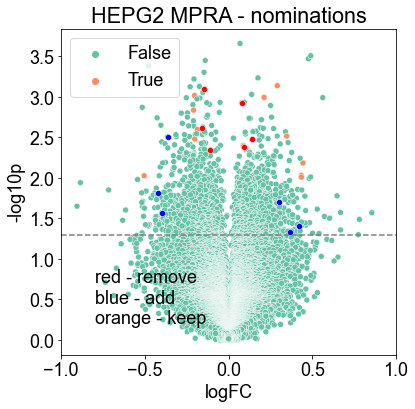

In [192]:
x= "logFC"
y= "-log10p"

data, id_ = data_dict["raw"]
fig, (ax1) = plt.subplots( figsize=(6,6))

sns.scatterplot(x=x, y=y, data=data, palette="Set2", ax=ax1, hue="candidate")
ax1.legend(title="candidate", bbox_to_anchor=(1,1))

# add
hue="nom_SF"
sns.scatterplot(x=x, y=y, data=data.loc[data["name"].isin(noms)], color="blue", ax=ax1)

# remove
hue="nom_SF"
sns.scatterplot(x=x, y=y, data=data.loc[data["name"].isin(remove)], color="red", ax=ax1)


# plot alpha
alpha= np.log10(0.05) *-1
ax1.axhline(alpha, ls="--", c="grey", label = "alpha")

ax1.set(title=f"{CL} MPRA - nominations", 
      xlim =(-1,1), )

ax1.text(-0.8,0.2, "red - remove\nblue - add\norange - keep")
plt.savefig(os.path.join(DATA_PATH, f"noms.{CL}.pdf"))

# for Giannini fellowship

## raw data

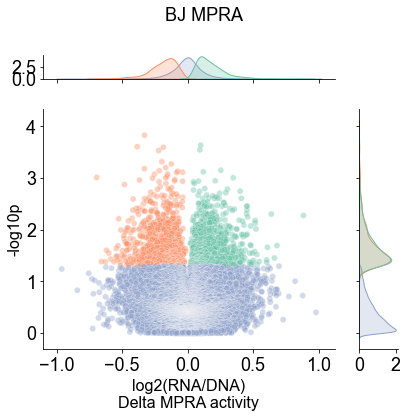

In [50]:
data, id_ = data_dict["raw"]
data["qual"] = "None"
data.loc[(data["sig"] == True) & (data["delta.med"]>0), "qual"] = "Activating"
data.loc[(data["sig"] == True) & (data["delta.med"]<0), "qual"] = "Silencing"

x= "delta.med"
y= "-log10p"
hue = "qual"
g = sns.jointplot(x=x,
              y=y,
              data=data,
              #color=color,
              hue=hue,
              hue_order=["Activating", 'Silencing', "None"],
              marginal_ticks=True, 
              alpha=0.4,
              marginal_kws={"common_norm":False}, 
              joint_kws={"legend":False}, 
              palette ="Set2",
              label = hue
         )



g.set_axis_labels("log2(RNA/DNA)\nDelta MPRA activity", '-log10p', fontsize=16)

g.fig.suptitle(' MPRA', size=18)
g.fig.tight_layout()


out = os.path.join(DATA_PATH, f"{CL}.delta.median.logp.png")

plt.savefig(out, bbox_inches="tight", dpi=90)

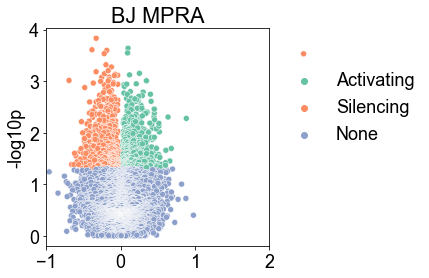

In [51]:
data["qual"] = "None"
data.loc[(data["sig"] == True) & (data["delta.med"]>0), "qual"] = "Activating"
data.loc[(data["sig"] == True) & (data["delta.med"]<0), "qual"] = "Silencing"

x= "delta.med"
y= "-log10p"
hue = "qual"

fig, ax=plt.subplots(figsize=(4,4))
sns.scatterplot(x=x,
              y=y,
              data=data,
              #color=color,
              hue=hue,
              hue_order=["Activating", 'Silencing', "None"],
              #alpha=0.4,
              palette ="Set2",
              label = hue
         )

ax.set(xlabel="",
    #xlabel="log2(RNA/DNA)\nDelta MPRA activity", 
       ylabel='-log10p', 
       title=' MPRA', 
      xlim=(-1,2))
ax.legend(['',"Activating", "Silencing", "None"],bbox_to_anchor=(1,1), frameon=False)

out = os.path.join(DATA_PATH, f"{CL}.delta.median.logp.scatter.standard.png")

plt.savefig(out, bbox_inches="tight", dpi=90)

## standard-scaled data

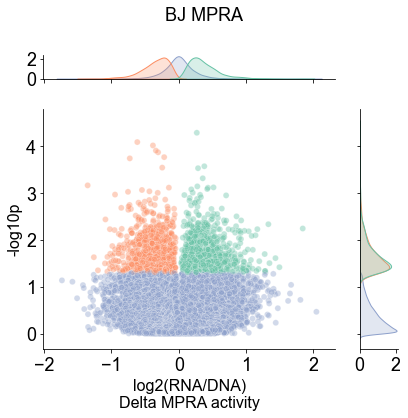

In [52]:
data, id_ = data_dict["standardized"]
data["qual"] = "None"
data.loc[(data["sig"] == True) & (data["delta.med"]>0), "qual"] = "Activating"
data.loc[(data["sig"] == True) & (data["delta.med"]<0), "qual"] = "Silencing"

x= "delta.med"
y= "-log10p"
hue = "qual"
g = sns.jointplot(x=x,
              y=y,
              data=data,
              #color=color,
              hue=hue,
              hue_order=["Activating", 'Silencing', "None"],
              marginal_ticks=True, 
              alpha=0.4,
              marginal_kws={"common_norm":False}, 
              joint_kws={"legend":False}, 
              palette ="Set2",
              label = hue
         )



g.set_axis_labels("log2(RNA/DNA)\nDelta MPRA activity", '-log10p', fontsize=16)

g.fig.suptitle(' MPRA', size=18)
g.fig.tight_layout()


out = os.path.join(DATA_PATH, f"{CL}.delta.median.logp.standardized.png")

plt.savefig(out, bbox_inches="tight", dpi=90)

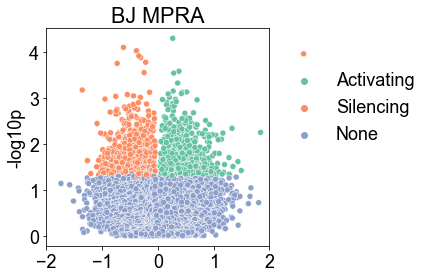

In [53]:
data["qual"] = "None"
data.loc[(data["sig"] == True) & (data["delta.med"]>0), "qual"] = "Activating"
data.loc[(data["sig"] == True) & (data["delta.med"]<0), "qual"] = "Silencing"

x= "delta.med"
y= "-log10p"
hue = "qual"

fig, ax=plt.subplots(figsize=(4,4))
sns.scatterplot(x=x,
              y=y,
              data=data,
              #color=color,
              hue=hue,
              hue_order=["Activating", 'Silencing', "None"],
              #alpha=0.4,
              palette ="Set2",
              label = hue
         )

ax.set(xlabel="",
    #xlabel="log2(RNA/DNA)\nDelta MPRA activity", 
       ylabel='-log10p', 
       title=' MPRA', 
      xlim=(-2,2))
ax.legend(['',"Activating", "Silencing", "None"],bbox_to_anchor=(1,1), frameon=False)

out = os.path.join(DATA_PATH, f"{CL}.delta.median.logp.scatter.standard.png")

plt.savefig(out, bbox_inches="tight", dpi=90)

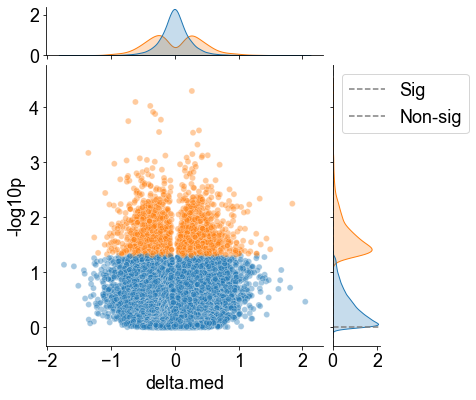

In [54]:
x="delta.med"
y= "-log10p"
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

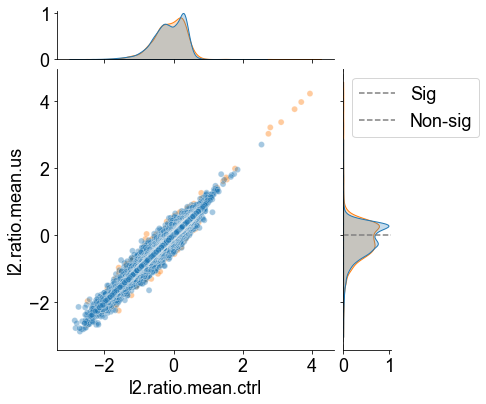

In [55]:
x= "l2.ratio.mean.ctrl"
y="l2.ratio.mean.us"

data, id_ = data_dict["raw"]

jointPlot(x, y, data, id_)

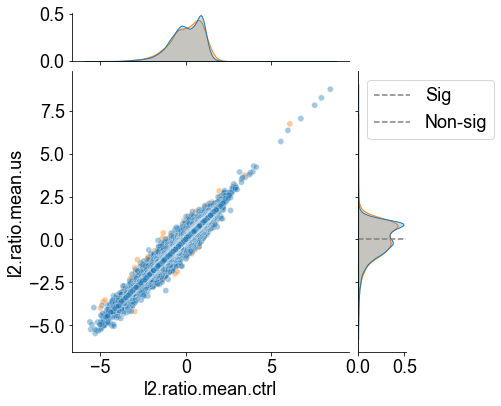

In [56]:
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

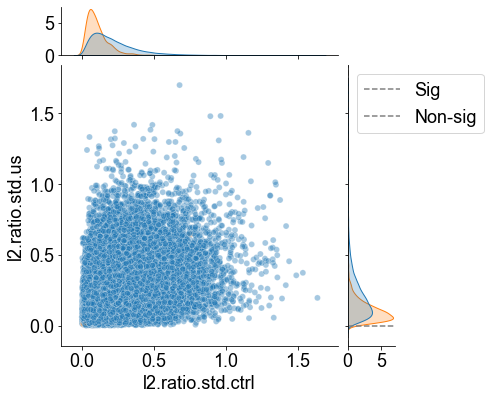

In [57]:
x= "l2.ratio.std.ctrl"
y="l2.ratio.std.us"
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

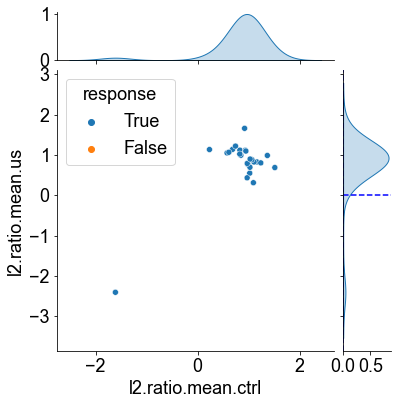

In [58]:
data, id_ = data_dict["standardized"] 
sns.jointplot(y="l2.ratio.mean.us", data=data.loc[data["response"]==True], x= "l2.ratio.mean.ctrl", 
                marginal_ticks=True, 
                hue_order = [True, False],
               hue='response')


#plt.plot(id_,id_, c="k", ls="--")
plt.axhline(0, c="b", ls="--")
plt.axvline(0, c="b", ls="--")